In [1]:
# 14/01/2022 Luís

# A first version of the HGO model.

# Need to check if the function is working accordingly to literature. Then I will irove the function, for example
# by implementing different loads as a function of a string argument of the function.
# For now it only allows a uniaxial load, assuming incompressibility of the material.

# It accepts a list of parameters params = [c, κ, k1, k2, a01, a02], a01 and a02 being 3 dimensional vectors.
# This might not be the best solution, maybe it would be better for the function to accept more arguments
# instead of this list of params.

# Need to get the stretch-strain curves by generating some parameters, like in the other notebooks.

# 16/01/2022 Luís

# Corrected some bugs in the code.

# The function returns the Cauchy stress tensor (T) after imposing of BC (T = T - (I*T[2,2]), because I was
# expecting T[0,0] == T[2,2], and only T[1,1] should be different from 0.)

# I have encountered some problems now. 
# I'm still not very familiar with anisotropy, so I dont't yet get
# how can I define the F matrix for a uniaxial load if the material is anisotropic.
# Has can be seen in the examples below, both T[0,0] and T[1,1] are different from 0, after imposing the BC.

# Is the F matrix not valid? Or have I not imposed the BC correctly?

# I am yet to confirm if the function is working accordingly to litterature.

#17/01/2022 Joao
# Because we are applying homogeneous deformation modes (uniaxial, biaxial, simple shear etc,..), 
# F only depends on the external loads/displacements applied to the material. Thus,  F it's the same. 
# In a more complex BVP, the F of each material point is obtained by approximation methods. For instance, the FEM. 
#
# I made some simplifications in your code. let's start with only one family of fibres. 
# if the material has two families, we can simply add two HGO calls. 


# 19/01/2022 Luís
# Now the fibers do not resist any compression. Examples with only tensile stresses remained the same.
# Example 2 now outputs null stresses, as expected.

# On Going: 
# generating data for several combinations of params
# modifying the function to accomodate equibiaxial loads

In [2]:
import pandas as pd
import random

import sympy as sym
from sympy.physics.quantum import TensorProduct

import numpy as np
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', None)

In [12]:
def double_dot(A,B):
    # Double-dot operation between two 3x3 matrices
    sum = 0
    for i in range(3):
        for j in range(3):
                sum = sum + A[i,j] * B[i,j]
    return sum


def HGO(params, stretch):
    #returns cauchy stress at yy direction
    
    #3x3 Identity Matrix
    I = sym.Matrix([[1,0,0],[0,1,0],[0,0,1]])
    
    # Deformation Gradient assuming incompressibility and a uniaxial load
    F=sym.Matrix([[1/(np.sqrt(stretch)),0,0], [0,stretch,0], [0,0,1/(np.sqrt(stretch))]])
    Ft=sym.transpose(F)
    
    Jac=sym.det(F)
    
    # Modified Deformation Gradient
    Fm = Jac**(-1/3) * I * F
    Fmt=sym.transpose(Fm)
    
    # Modified Right Cauchy-Green Deformation Tensor with values accoring to F 'Cmv'
    Cmv=Fmt*Fm
    
    Cm11v=Cmv[0,0]
    Cm12v=Cmv[0,1]
    Cm13v=Cmv[0,2]
    Cm21v=Cmv[1,0]
    Cm22v=Cmv[1,1]
    Cm23v=Cmv[1,2]
    Cm31v=Cmv[2,0]
    Cm32v=Cmv[2,1]
    Cm33v=Cmv[2,2]
    
    # Symbolic Modified Right Cauchy-Green Deformation Tensor 'Cm'
    Cm11 = sym.Symbol('Cm11')
    Cm12 = sym.Symbol('Cm12')
    Cm13 = sym.Symbol('Cm13')
    Cm21 = sym.Symbol('Cm21')
    Cm22 = sym.Symbol('Cm22')
    Cm23 = sym.Symbol('Cm23')
    Cm31 = sym.Symbol('Cm31')
    Cm32 = sym.Symbol('Cm32')
    Cm33 = sym.Symbol('Cm33')
    Cm = sym.Matrix([[Cm11,Cm12,Cm13], [Cm21,Cm22,Cm23], [Cm31,Cm32,Cm33]])  
    
    # Compute the invariant im1  of the tensor Cm
    im1=sym.trace(Cm)
    
    #symbolic Neo-Hookean parameter c
    c = sym.Symbol('c')
    
    # symbolic dispersion parameter κ (0 < κ < 1/3) (the symbol is the greek letter 'kappa')
    κ = sym.Symbol('κ')
    
    # symbolic material parameters k1 and k2 (k1>0; k2>0)
    k1=sym.Symbol('k1')
    k2=sym.Symbol('k2')
    
    # Unit vector representing the direction of the fibres in the stress free configuration
    a01_1 = params[4][0]
    a01_2 = params[4][1]
    a01_3 = params[4][2]
    a01 = sym.Matrix([a01_1, a01_2, a01_3])
    
    # Structure Tensors H1, which depend on κ and a01
    
    if double_dot(Cmv, TensorProduct(a01,sym.transpose(a01))) > 1:   # condition to only allow tensile stress
        H1 = κ*I + (1-3*κ)*(TensorProduct(a01,sym.transpose(a01)))
    else:
        H1 = κ*I
        
    E1 = double_dot(H1,Cm) - 1
    
    #alternative: for debbugging 
    #m0 =TensorProduct(a01,sym.transpose(a01))
    #im4 = double_dot(Cm,m0) #pseudo-invariant 4. very important measure. it tells us the squared stretch of the fibers
    #E1 = im4*(1-3*κ) + κ*im1-1
    
    #Generate SEF (Strain Energy Function)
    sef= 0.5 * c * (im1 - 3) + (k1/(2*k2)) * (sym.exp(k2*E1*E1) - 1)
    
    #Second Piola Kirchoff Stresses
    S11=2*sym.diff(sef,Cm11)
    S12=2*sym.diff(sef,Cm12)
    S13=2*sym.diff(sef,Cm13)
    S21=2*sym.diff(sef,Cm21)
    S22=2*sym.diff(sef,Cm22)
    S23=2*sym.diff(sef,Cm23)
    S31=2*sym.diff(sef,Cm31)
    S32=2*sym.diff(sef,Cm32)
    S33=2*sym.diff(sef,Cm33)
    S = sym.Matrix([[S11,S12,S13], [S21,S22,S23], [S31,S32,S33]])
    
    
    T = (1/Jac)*(F*S*Ft) # cauchy stresses with no BCs
    T = T - (I*T[2,2]) # imposing of boundary conditions
    
    T=T.subs([(Cm11, Cm11v), (Cm12, Cm12v), 
                                  (Cm13, Cm13v),(Cm21, Cm21v), 
                                  (Cm22, Cm22v), (Cm23, Cm23v),
                                  (Cm31, Cm31v), (Cm32, Cm32v), 
                                  (Cm33, Cm33v),(c,params[0]), 
                                  (κ,params[1]),(k1,params[2]),(k2,params[3])])
    
    return stretch, T

def get_curve(params,stretch_min,stretch_max,ninc):
    #stores HGO loading runs between a minimum and a maximum stretch
    lst=[HGO(params, stretch) for stretch in np.linspace(stretch_min,stretch_max,ninc)]
    return lst

Let us aplly our function to some examples

In [4]:
# Example 1
# evaluated for unitary parameters. no dispersion

c= 1 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented along the pulling direction
a01 = [0,1,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2

[stretch, stress] = HGO(params, stretch)

stress # in kPa

Matrix([
[0,                0, 0],
[0, 2.14455419836872, 0],
[0,                0, 0]])

In [5]:
# Example 2
#evaluated for unitary parameters. no dispersion

c= 0 # pressure units
κ = 0.0
k1 = 1.0 # pressure units
k2 = 1.0
#let's test for a simple case: fibers oriented transversal to the pulling direction
a01 = [1,0,0]
#a01 = [-np.sin(np.deg2rad(90)),np.cos(np.deg2rad(0)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2

[stretch, stress] = HGO(params, stretch)

stress # in pressure units

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [6]:
# Example 3
# κ = 1/3, which means that the material is isotropic, i.e. Neo Hooke material.

c= 1 # pressure units
κ = 1/3
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2

[stretch, stress] = HGO(params, stretch)

stress  # in pressure units

Matrix([
[0,                 0, 0],
[0, 0.621065104548954, 0],
[0,                 0, 0]])

In [7]:
# Example 4
# κ = 0.1, arbitrary orientation. 


c= 1.0 # pressure units
κ = 0.1
k1 = 1.0 # pressure units
k2 = 1.0
a01 = [-np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]
#a02 = [np.sin(np.deg2rad(65)),np.cos(np.deg2rad(65)),0]


params = [c, κ, k1, k2, a01]
stretch = 1.2

[stretch, stress] = HGO(params, stretch)

stress  # in pressure units

Matrix([
[0,                 0, 0],
[0, 0.472149517852544, 0],
[0,                 0, 0]])

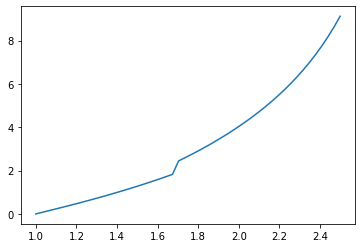

In [18]:
check = np.array(get_curve(params,1,2.5,50))

plt.plot(check[:,0],check[:,1])